## In this notebook: 
## 1. Clustering 2 and 3 point percentage for NBA players that shoot a respectable amount of 3 pointers
## 2. Clustering players based on advanced box score metrics, OBPM (offensive box plus/minus) and DBPM (defensive box plus/minus) 
## 3. PCA based clustering
####    

### Module versions used in this notebook

In [1]:
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn


print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('sklearn: {}'.format(sklearn.__version__))

Python: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
scipy: 1.1.0
numpy: 1.15.4
matplotlib: 3.0.2
pandas: 0.23.4
sklearn: 0.20.2


In [2]:
import pandas as pd
import numpy as np
import sklearn
import keras
import matplotlib.pyplot as plt

from matplotlib import style
style.use("ggplot")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans

import time

Using TensorFlow backend.


## 1. Clustering 2 and 3 point percentage for NBA players that shoot a respectable amount of 3 pointers

### Use pandas to read the csv and create a dataframe

In [3]:
df = pd.read_csv("/Users/tommykwan/Documents/MachineLearning/Unsupervised/KMeansClustering/NBA_Clustering/season_data_2018_2019.csv")
df.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Alex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


### Keep only the total numbers for players that played on multiple teams during the season


In [4]:
df = df.drop_duplicates(keep = 'first')

### Putting some requirements on the players that are being considered (otherwise, extreme outliers appear in the data)

In [5]:
# >50 games played out of 82
df = df[df['G'] > 50]

# >1.5 3-point attempts/game
df = df[df['Three_PA'] > 1.5]

# >3 field goal attempts/game
df = df[df['FGA'] > 3]

# >15 minutes played/game
df = df[df['MP'] > 15]

#drop N/A data
df = df.dropna()

df = df.drop(columns = ['Player','Pos','Tm','G','GS','Age','Rk'])

df.head(5)


,MP,FG,FGA,FGP,Three_P,Three_PA,Three_PP,Two_P,Two_PA,Two_PP,...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
12,28.3,3.2,7.3,0.433,1.2,3.5,0.343,2.0,3.9,0.514,...,0.867,1.4,6.1,7.5,1.3,0.8,0.4,0.9,1.8,9.4
19,32.8,10.0,17.3,0.578,0.7,2.8,0.256,9.3,14.5,0.641,...,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7
22,20.2,2.7,6.0,0.453,1.0,3.0,0.332,1.7,3.0,0.574,...,0.581,0.9,2.1,2.9,0.7,0.7,0.3,0.8,2.1,7.0
23,24.2,2.3,5.2,0.447,1.0,2.7,0.373,1.3,2.5,0.527,...,0.873,0.3,2.4,2.7,3.3,0.8,0.0,0.8,2.1,6.7
24,34.0,4.3,10.7,0.399,2.1,6.3,0.334,2.2,4.4,0.493,...,0.793,0.7,4.7,5.4,3.7,1.3,0.3,1.5,1.9,12.5


### Keep only 2 and 3 point percentage in a non-PCA k-means clustering

In [6]:
df = df[["Two_PP","Three_PP"]]
df.head(5)

,Two_PP,Three_PP
12,0.514,0.343
19,0.641,0.256
22,0.574,0.332
23,0.527,0.373
24,0.493,0.334


In [7]:
X = np.array(df)

### 4 clusters chosen as hypothesis: 
### 1. High 2P%, High 3P% (top right - superstars that can shoot and great role players)
### 2. Low 2P%, Low 3P% (bottom left - subpar players or players in bad system)
### 3. High 2P%, Low 3P% (bottom right - big men and non 3 point shooting slashers)
### 4. Low 2P%, High 3P% (bottom left - 3 point shooting role players, designated shooters)

In [8]:
kmeans = KMeans(n_clusters = 4)

start = time.time()
kmeans.fit(X)
end = time.time()

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [9]:
print('Centroids created with 4-means clustering:')
print(centroids)

Centroids created with 4-means clustering:
[[0.60947368 0.33257895]
 [0.46160227 0.34702273]
 [0.53663492 0.33687302]
 [0.51094444 0.40201852]]


In [10]:
print('Cluster labels corresponding to each player in the dataset:')
print(labels)

Cluster labels corresponding to each player in the dataset:
[2 0 0 3 1 3 1 3 1 2 3 1 2 3 1 3 0 1 3 2 1 2 2 3 2 2 2 1 1 1 1 1 2 1 3 1 1
 2 0 2 3 1 0 2 1 2 3 3 2 2 2 2 1 2 0 2 2 0 1 2 2 3 2 1 1 3 1 1 1 3 3 3 1 1
 3 1 3 2 2 3 0 2 1 2 0 1 1 3 3 3 2 2 2 1 3 2 2 1 1 0 1 0 0 1 3 2 3 2 2 2 1
 2 2 1 0 2 1 1 1 2 1 1 3 0 1 3 1 2 2 1 3 0 2 2 3 2 2 0 2 2 1 1 2 1 1 3 3 1
 3 1 1 3 2 1 1 3 3 1 3 1 1 2 1 1 2 1 1 0 1 2 2 1 3 0 3 2 3 1 2 3 3 1 1 1 3
 3 3 1 1 1 1 3 3 1 0 1 2 1 1 3 1 1 2 3 1 3 3 1 3 1 2 2 1 1 3 1 2 1 1 3 1 1
 2 1]


In [11]:
print('Total fit time: ' + str(end-start) + ' seconds')

Total fit time: 0.04087972640991211 seconds


### Import the original 2018-2019 NBA season data from basketball reference for plotting purposes

In [12]:
df2 = pd.read_csv("/Users/tommykwan/Documents/MachineLearning/Unsupervised/KMeansClustering/NBA_Clustering/season_data_2018_2019.csv")
df2 = df2.drop_duplicates(keep = 'first')

### Plot the clusters and centroids while labelling outstanding players

Text(0, 0.5, '3P%')

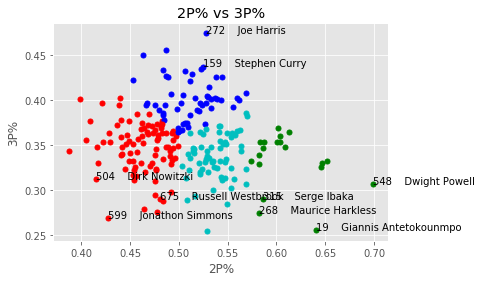

In [13]:
colors = ["g.","r.","c.","b."]
ax = plt.subplot()

for i in range(len(X)):
    ax.plot(X[i][0], X[i][1],colors[labels[i]], markersize=10)
    if X[i][0] > np.percentile(X[:,0],90) and X[i][1] > np.percentile(X[:,1],90):
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if X[i][0] < np.percentile(X[:,0],10) and X[i][1] < np.percentile(X[:,1],10):
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if X[i][0] > np.percentile(X[:,0],90) and X[i][1] < np.percentile(X[:,1],10):
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if X[i][0] < np.percentile(X[:,0],10) and X[i][1] > np.percentile(X[:,1],90):
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
        
    # Stephen Curry   
    if (df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player'].to_string().split('\\')[0]) == "159    Stephen Curry":
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
    
    # Joe Harris
    if (df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player'].to_string().split('\\')[0]) == "272    Joe Harris":
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    #Russell Westbrook
    if (df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player'].to_string().split('\\')[0]) == "675    Russell Westbrook":
        txt = df2.loc[(df2['Two_PP'] == X[i][0]) & (df2['Three_PP'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)


ax.set_title('2P% vs 3P%')
ax.set_xlabel('2P%')
ax.set_ylabel('3P%')

### Centroids-only plot

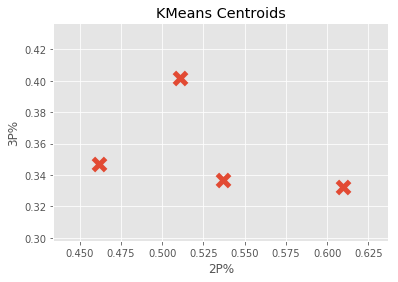

In [14]:
plt.scatter(centroids[:,0],
            centroids[:,1],
            marker='x',
            s=150,
            linewidth=5)

plt.title('KMeans Centroids')
plt.xlabel('2P%')
plt.ylabel('3P%')
plt.show()

### Results show decent results as hypothesized

## 2. Clustering players based on advanced box score metrics, OBPM (offensive box plus/minus) and DBPM (defensive box plus/minus) 

In [15]:
df = pd.read_csv("/Users/tommykwan/Documents/MachineLearning/Unsupervised/KMeansClustering/NBA_Clustering/nba_advanced_stats_2018_2019.csv")

In [16]:
df.head()

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Alex Abrines\abrinal01,SG,25,OKC,31,588,6.3,0.507,0.809,...,7.9,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,123,2.9,0.379,0.833,...,15.2,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,428,7.6,0.474,0.673,...,19.7,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3
3,4,Steven Adams\adamsst01,C,25,OKC,80,2669,18.5,0.591,0.002,...,12.6,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,1913,17.9,0.623,0.031,...,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4


In [17]:
df = df.drop_duplicates(keep = 'first')

### Again, putting some requirements on the players that are being considered and dropping all features except OBPM and DBPM

In [18]:
df = df[df['G'] > 50]
df = df[df['MP'] > 750]
df = df.dropna()
df = df[['OBPM','DBPM']]
X = np.array(df)

### 4 clusters chosen as hypothesis: 
### 1. High OBPM, High DBPM (top right - great offensive and defensive players)
### 2. Low OBPM, Low DBPM (bottom left - subpar offensive and defensive players)
### 3. High OBPM, Low DBPM (bottom right - great offensive but subpar defensive players)
### 4. Low OBPM, High DBPM (bottom left - subpar offensive but great defensive players)

In [19]:
kmeans = KMeans(n_clusters = 4)

start = time.time()
kmeans.fit(X)
end = time.time()

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [20]:
print('Total fit time: ' + str(end-start) + ' seconds')

Total fit time: 0.04559493064880371 seconds


In [21]:
print('Centroids:')
print(centroids)

Centroids:
[[ 4.43928571  0.78214286]
 [-0.07236842  1.98815789]
 [-1.925      -0.42065217]
 [ 0.63043478 -1.49565217]]


In [22]:
print('Labels:')
print(labels)

Labels:
[1 1 1 1 1 0 2 3 3 3 1 2 3 1 1 2 0 3 3 1 2 3 1 2 1 2 0 3 3 3 2 2 2 3 2 2 2
 3 3 3 3 2 0 0 3 1 2 3 1 2 2 2 3 3 1 3 0 1 3 1 2 1 1 3 0 3 0 1 1 1 2 1 3 0
 2 1 2 0 3 1 2 2 1 2 3 1 3 3 3 2 0 3 1 1 1 0 3 2 2 1 1 3 1 2 1 1 3 2 3 0 3
 0 1 0 2 2 3 3 3 2 2 1 2 3 2 3 2 0 2 2 1 3 1 2 1 1 2 1 2 0 1 2 2 1 2 3 2 3
 0 3 2 2 2 0 1 3 1 2 3 3 2 1 2 3 3 2 3 3 3 3 3 0 3 0 2 3 2 1 1 2 0 2 2 2 2
 3 3 3 2 3 1 2 2 3 2 3 3 1 3 3 3 3 2 3 3 3 3 1 3 1 2 1 2 1 2 2 2 1 3 2 1 2
 3 2 0 1 1 3 0 2 3 3 3 2 1 3 3 2 1 0 1 3 3 3 2 2 2 3 3 3 2 1 1 2 1 2 2 2 3
 2 2 2 1 3 2 0 2 1 2 1 3 1 0 2 0 3 1 1 1 2 3 1 1 1 1 3 2 1]


In [23]:
df2 = pd.read_csv("/Users/tommykwan/Documents/MachineLearning/Unsupervised/KMeansClustering/NBA_Clustering/nba_advanced_stats_2018_2019.csv")
df2 = df2.drop_duplicates(keep = 'first')

Text(0, 0.5, 'DBPM')

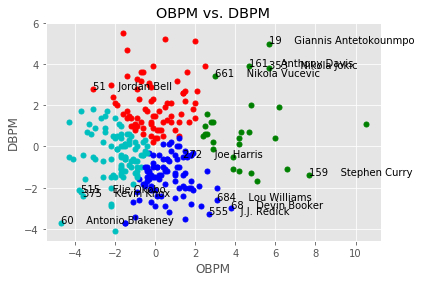

In [24]:
colors = ["g.","r.","c.","b."]
ax = plt.subplot()

for i in range(len(X)):
    ax.plot(X[i][0], X[i][1],colors[labels[i]], markersize=10)
    if X[i][0] > np.percentile(X[:,0],90) and X[i][1] > np.percentile(X[:,1],90):
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if X[i][0] < np.percentile(X[:,0],10) and X[i][1] < np.percentile(X[:,1],10):
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if X[i][0] > np.percentile(X[:,0],90) and X[i][1] < np.percentile(X[:,1],10):
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if X[i][0] < np.percentile(X[:,0],10) and X[i][1] > np.percentile(X[:,1],90):
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if (df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player'].to_string().split('\\')[0]) == "159    Stephen Curry":
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if (df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player'].to_string().split('\\')[0]) == "272    Joe Harris":
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]
        ax.annotate(txt,[X[i][0],X[i][1]],rotation = 0)
        
    if (df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player'].to_string().split('\\')[0]) == "675    Russell Westbrook":
        txt = df2.loc[(df2['OBPM'] == X[i][0]) & (df2['DBPM'] == X[i][1]),'Player']
        txt = txt.to_string().split('\\')[0]

ax.set_title('OBPM vs. DBPM')
ax.set_xlabel('OBPM')
ax.set_ylabel('DBPM')  

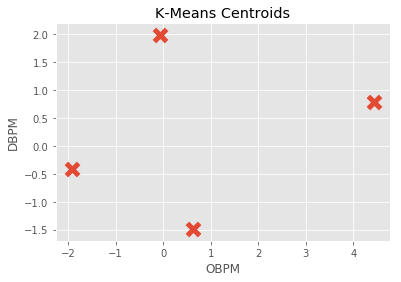

In [25]:
plt.scatter(centroids[:,0],
            centroids[:,1],
            marker='x',
            s=150,
            linewidth=5)

plt.title('K-Means Centroids')
plt.xlabel('OBPM')
plt.ylabel('DBPM')
plt.show()

## 3. PCA based clustering (standard data - non-advanced)

In [26]:
df = pd.read_csv("/Users/tommykwan/Documents/MachineLearning/Unsupervised/KMeansClustering/NBA_Clustering/season_data_2018_2019.csv")

In [27]:
# >50 games played out of 82
df = df[df['G'] > 50]

# >1.5 3-point attempts/game
df = df[df['Three_PA'] > 1.5]

# >3 field goal attempts/game
df = df[df['FGA'] > 3]

# >15 minutes played/game
df = df[df['MP'] > 15]

#drop N/A data
df = df.dropna()

#extract names for plotting later
names = df['Player']


#drop non-numeric/irrelevant data
df = df.drop(columns = ['Player','Pos','Tm','G','GS','Age','Rk'])

df.head(5)

,MP,FG,FGA,FGP,Three_P,Three_PA,Three_PP,Two_P,Two_PA,Two_PP,...,FTP,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
12,28.3,3.2,7.3,0.433,1.2,3.5,0.343,2.0,3.9,0.514,...,0.867,1.4,6.1,7.5,1.3,0.8,0.4,0.9,1.8,9.4
19,32.8,10.0,17.3,0.578,0.7,2.8,0.256,9.3,14.5,0.641,...,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7
22,20.2,2.7,6.0,0.453,1.0,3.0,0.332,1.7,3.0,0.574,...,0.581,0.9,2.1,2.9,0.7,0.7,0.3,0.8,2.1,7.0
23,24.2,2.3,5.2,0.447,1.0,2.7,0.373,1.3,2.5,0.527,...,0.873,0.3,2.4,2.7,3.3,0.8,0.0,0.8,2.1,6.7
24,34.0,4.3,10.7,0.399,2.1,6.3,0.334,2.2,4.4,0.493,...,0.793,0.7,4.7,5.4,3.7,1.3,0.3,1.5,1.9,12.5


### Use standardscaler to scale the dataset and choose 3 principal components for visualization

In [28]:
X = np.array(df)
X = StandardScaler().fit_transform(X)

pca = PCA(n_components = 3)

start = time.time()
principalComponents = pca.fit_transform(X)
end = time.time() 

In [29]:
print('Total fit time: ' + str(end-start) + ' seconds')

Total fit time: 0.005650997161865234 seconds


In [30]:
print('Explained variance from each principal component')
print(pca.explained_variance_ratio_)

Explained variance from each principal component
[0.47176242 0.16319464 0.1071041 ]


In [31]:
print('Total variance explained')
print(sum(pca.explained_variance_ratio_))

Total variance explained
0.7420611574933331


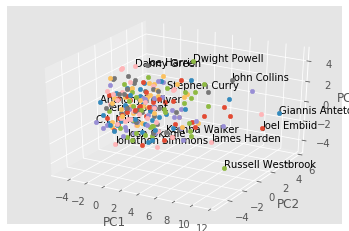

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')

ax3D.set_xlabel('PC1')
ax3D.set_ylabel('PC2')
ax3D.set_zlabel('PC3')

percentilePC1High = np.percentile(principalComponents[:,0],99)
percentilePC2High = np.percentile(principalComponents[:,1],99)
percentilePC3High = np.percentile(principalComponents[:,2],99)
percentilePC1Low = np.percentile(principalComponents[:,0],1)
percentilePC2Low = np.percentile(principalComponents[:,1],1)
percentilePC3Low = np.percentile(principalComponents[:,2],1)

for i in range(len(principalComponents)):
    ax3D.scatter(principalComponents[i][0],principalComponents[i][1],principalComponents[i][2])
    if principalComponents[i][0] > percentilePC1High or principalComponents[i][1] > percentilePC2High or principalComponents[i][0] < percentilePC1Low or principalComponents[i][1] < percentilePC2Low or principalComponents[i][2] > percentilePC3High or principalComponents[i][2] < percentilePC3Low:
            txt = names.values[i].split('\\')[0]
            ax3D.text(principalComponents[i][0],
                       principalComponents[i][1],
                      principalComponents[i][2],
                      txt,
                      None)